# Error fields
This notebook presents the error field computation using the function `DIVAnd_errormap`.
Details can be found in the publication:

> Approximate and Efficient Methods to Assess Error Fields in Spatial Gridding with Data Interpolating Variational Analysis (DIVA) Beckers, Jean-Marie; Barth, Alexander; Troupin, Charles, Alvera-Azcarate, A. _Journal of Atmospheric & Oceanic Technology_ (2014), __31(2)__, 515-530      
https://orbi.uliege.be/handle/2268/161069       
https://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00130.1

but two additional methods (`:scpme` and `:diagapp`) are not described there.

In [1]:
using DIVAnd
using Makie
using CairoMakie
using GeoMakie
using Dates
using Statistics
using LinearAlgebra
include("../config.jl")

"https://dox.uliege.be/index.php/s/h8d3pyqmuea6J9H/download"

## Data reading
Download the file (it not already done) and read it.

In [2]:
varname = "Salinity"
filename = salinityprovencalfile
download_check(salinityprovencalfile, salinityprovencalfileURL)

[ Info: File already downloaded


In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64, filename, "Salinity");

## Topography and grid definition
See the notebook on [bathymetry](../2-Preprocessing/06-topography.ipynb) for more explanations.

Define domain and resolution, create the domain.

In [4]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr);

Download the bathymetry file and load it.

In [5]:
bathname = gebco04file
download_check(gebco04file, gebco04fileURL)

[ Info: File already downloaded


In [6]:
bx, by, b = load_bath(bathname,true,lonr,latr);

Create a land-sea mask based on the bathymetry at 1 meter depth.

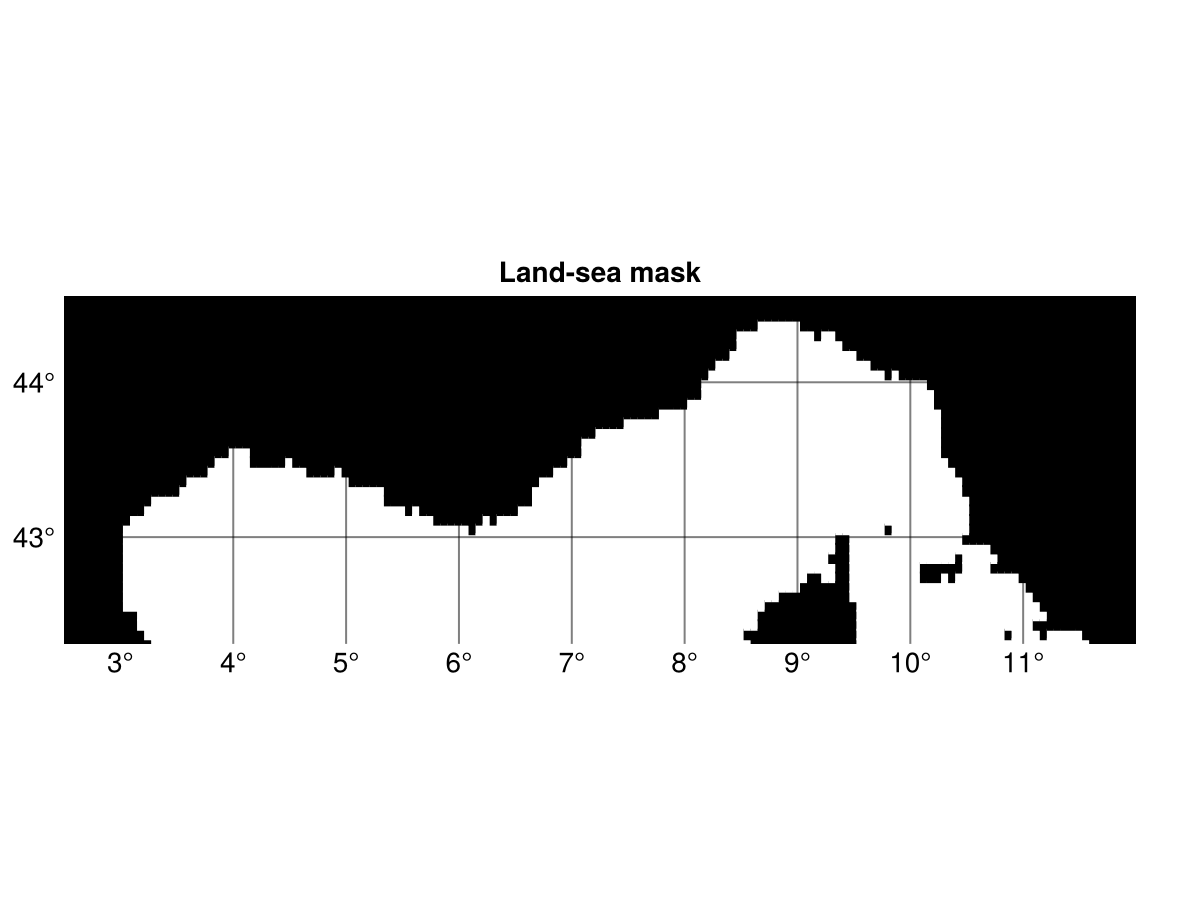

In [7]:
mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

plot_mask(bx, by, mask)

## Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here we limit outselves to August data at surface:

In [8]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)


[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (DateTime("1910-08-09T00:00:00"), DateTime("2014-08-28T19:36:00"))
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis
The parameters have been calibrated in the other notebook [13-processing-parameter-optimization example.ipynb](13-processing-parameter-optimization). 

<div class="alert alert-block alert-warning"> 
  ⚠️ If the statistical parameters are incorrectly estimated, the error fields are meaningless and only provide an idea of data coverage.
</div>

The analysis parameters are:

In [9]:
len = 0.3
epsilon2 = 1.4;

Analysis `fi` using mean data as background.    
Structure `s` is stored for later use in error calculation.
Note that the background is just data average  `mean(obsval)`

In [10]:
 fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

### Create a simple plot of the analysis

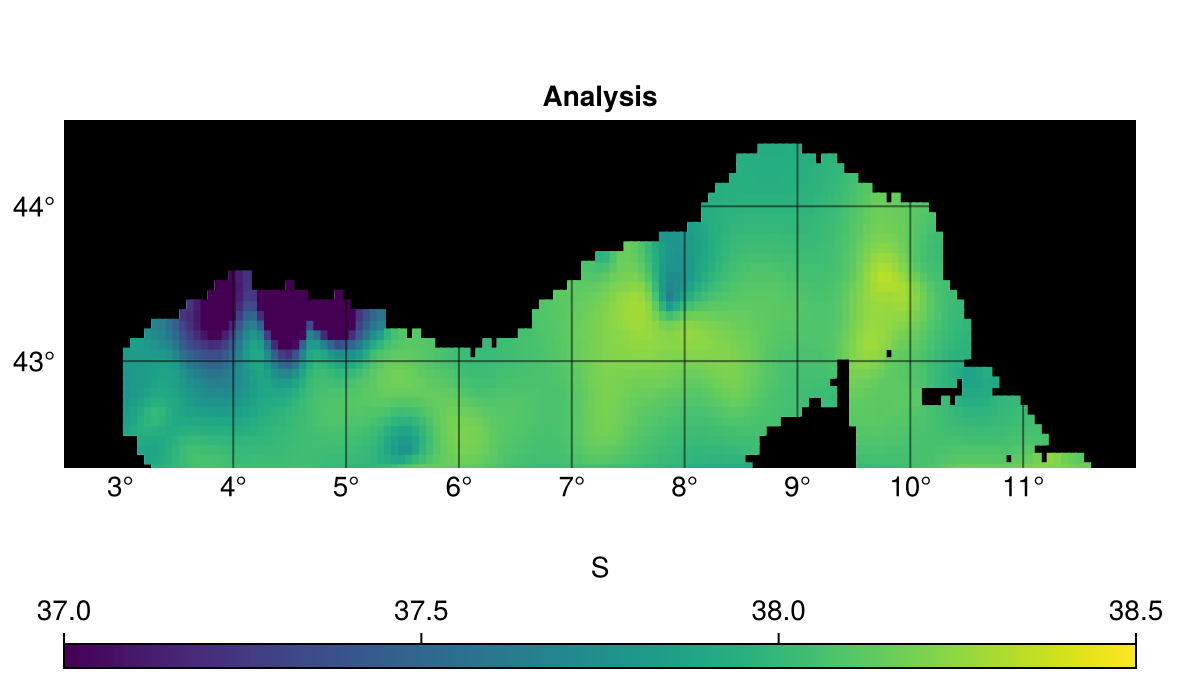

In [11]:
fig = Figure(size = (600, 350))
ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = "Analysis", 
xticks=2.:1.:14, yticks=42.:1.:45.)
heatmap!(ga, bx, by, mask, colormap=Reverse(:binary))
hm = heatmap!(ga, lonr, latr, fi .+ mean(obsval), interpolate = false, colorrange=[37., 38.5])
# sc = scatter!(obslon, obslat, color=obsval, markersize=7, colorrange=[37., 38.5])
xlims!(ga, (bx[1], bx[end]))
ylims!(ga, (by[1], by[end]))
Colorbar(fig[2, 1], hm, vertical = false, label = "S")
fig

## Exact error and approximations

<div class="alert alert-block alert-info"> 
🛈 Details can be found in the publication mentioned at the beginning of the notebook.
</div>

First we define a utility function for plotting.

In [12]:
function ploterr(exerr; vmin=0, vmax=1.5, cmap=Reverse(:hot), figtitle="Error field")
    fig = Figure(size = (600, 350))
    ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = figtitle, 
    xticks=2.:1.:14, yticks=42.:1.:45.)
    heatmap!(ga, bx, by, mask, colormap=Reverse(:binary))
    hm = heatmap!(ga, lonr, latr, exerr, colormap=cmap, interpolate = false, colorrange=[vmin, vmax])
    # sc = scatter!(obslon, obslat, color=obsval, markersize=7, colorrange=[37., 38.5])
    xlims!(ga, (bx[1], bx[end]))
    ylims!(ga, (by[1], by[end]))
    Colorbar(fig[2, 1], hm, vertical = false)
    fig
end

ploterr (generic function with 1 method)

### Exact error by hand

In the 2D case you can try to calculate the exact error expression. This demands the computationally expensive evaluation of `diag(s.P)` accessible via the analysis returned structure `s`. The latter is only available with `DIVAndrun`.

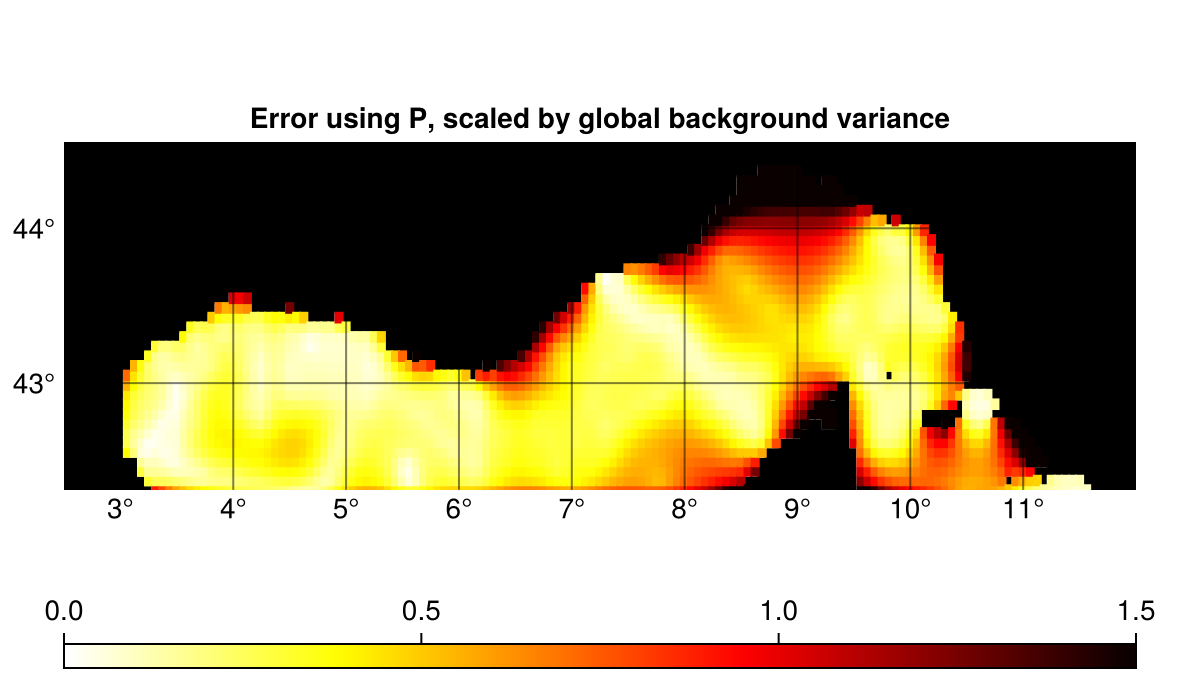

In [13]:
exerr, = statevector_unpack(s.sv,diag(s.P),NaN)
ploterr(exerr, figtitle="Error using P, scaled by global background variance")

### Exact error as a choice via the errormap function

In [14]:
aerrora,method = DIVAnd_errormap(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2,
    s;
    method = :exact,
    Bscale = false)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], :exact)

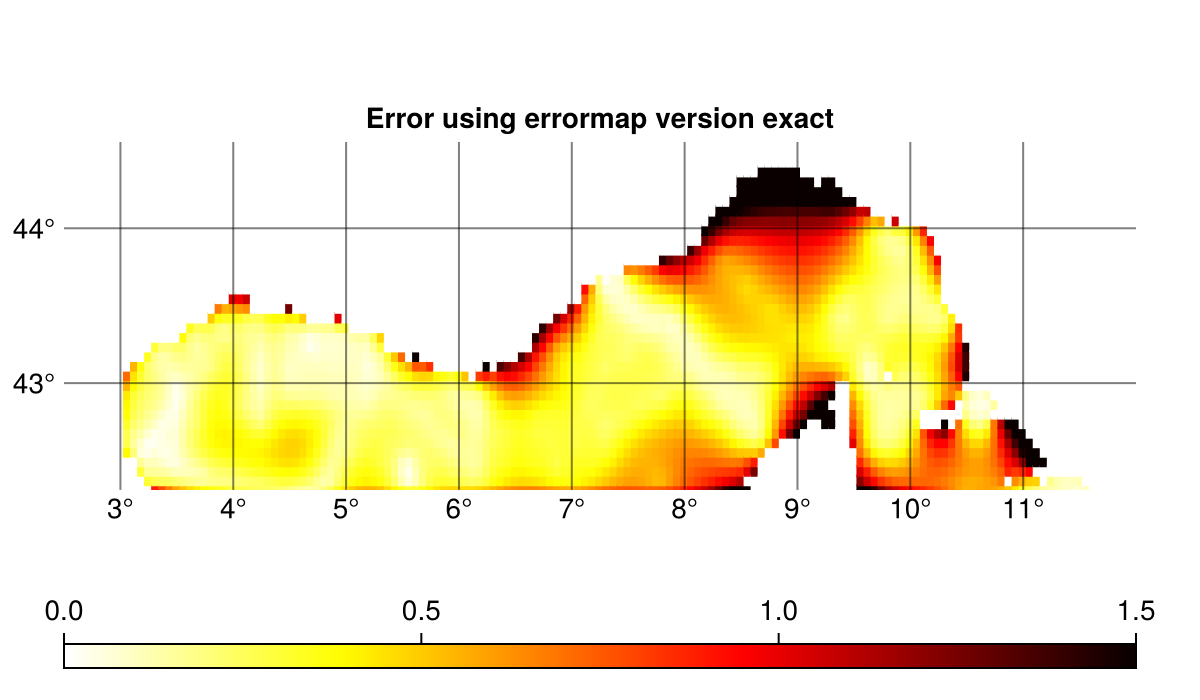

In [15]:
ploterr(aerrora, figtitle="Error using errormap version $method")

# Other options
## Precise version, actual method chosen will depend on data coverage

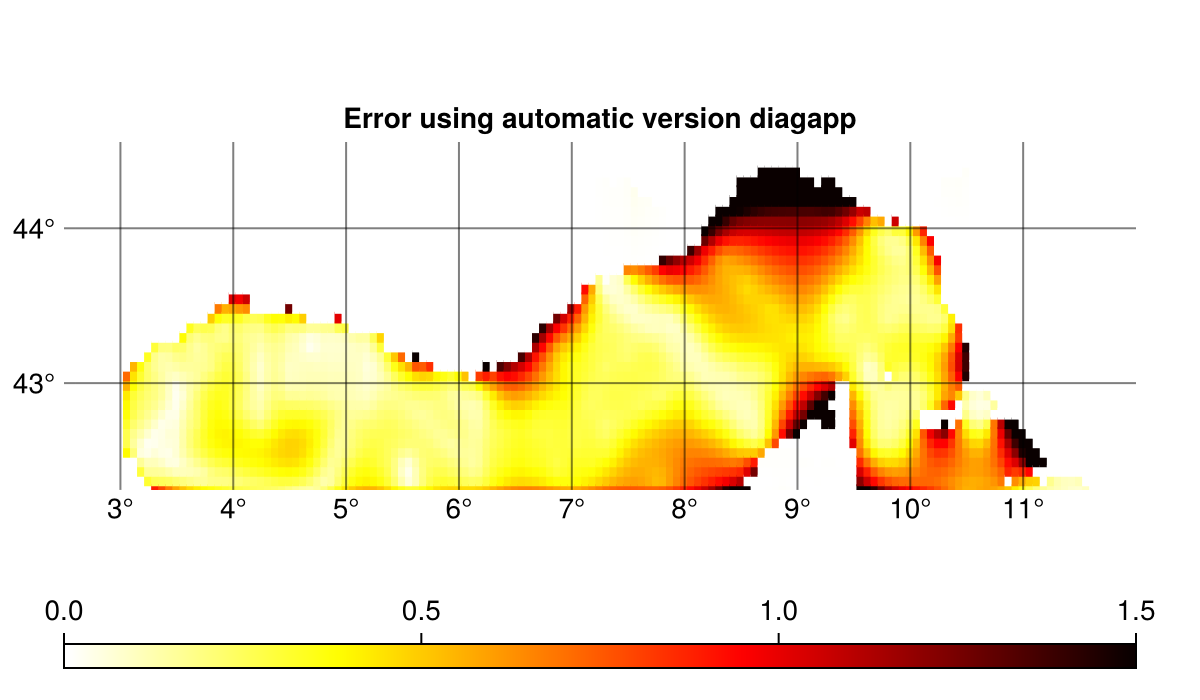

In [16]:
aerror,method = DIVAnd_errormap(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2,
    s;
    method = :precise,
    Bscale = false)
ploterr(aerror, figtitle="Error using automatic version $method")

Difference between error fields.
We also overlay the data positions.

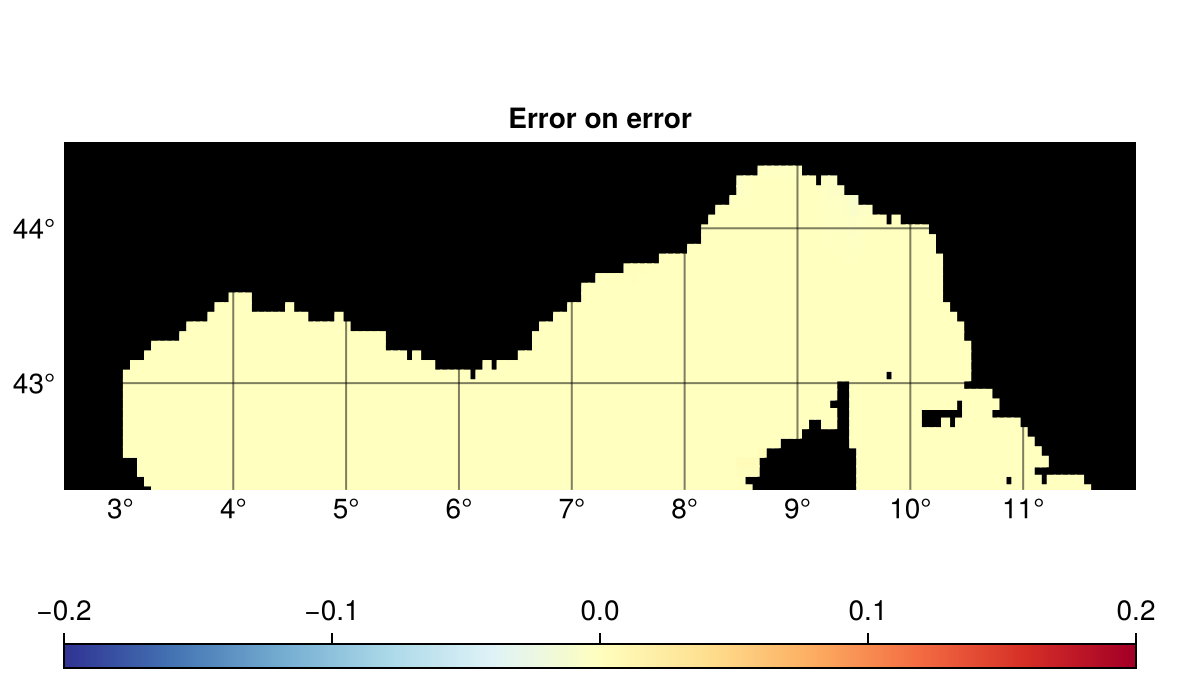

In [17]:
ploterr(aerror-exerr,vmin=-0.2, vmax=0.2, cmap=Reverse(:RdYlBu), figtitle="Error on error")

### Other options 
The method offers other options:
- `:auto`, 
- `:cheap` will automatically chose between `:scpme` (for a lot of data) or `:cpme` (for a few isolated data points) 
- `:precise` will automatically chose between the methods very close to the exact version.
- `:cpme`,
- `:scpme`,
- `:exact`,
- `:aexerr`,
- `:diagapp`

## How to plot standard deviations ?

Error fields shown above are error variance divided by a global background error variance $\sigma^2$. The latter is difficult to assess but a simple practical way is to use data variance VAR and split it into background error variance $\sigma^2$ and observational error variance $\epsilon^2$, assuming the $epsilon2$ value is correct ($epsilon2$ is the parameter used in `DIVAndrun` and is the relative observational error variance). VAR is the total variance of your data.

$epsilon2$ = ${ \epsilon^2 \over \sigma^2 } $

$ \epsilon^2 + \sigma^2 $ = VAR

Provides

$\sigma^2$= $ {1 \over 1 + epsilon2 }$ VAR

$\epsilon^2$= $ {epsilon2 \over 1 + epsilon2 }$ VAR

If you are not sure about the value of $epsilon2$ you might consider using `DIVAnd_adaptedeps2(s, fi)`. 

<div class="alert alert-block alert-info"> 
🛈 If you do this and see a completely different value of $epsilon2$, you should probably rerun the analysis and error calculation before trying to get the absolute errors.
</div>

In [18]:
epsilon2n=epsilon2*DIVAnd_adaptedeps2(s, fi)
VAR=var(obsval)
eps2=epsilon2n/(1.0+epsilon2n)*VAR
sig2=1.0/(1.0+epsilon2n)*VAR
@show eps2,sig2,eps2+sig2,VAR,eps2/sig2,epsilon2n,epsilon2

(eps2, sig2, eps2 + sig2, VAR, eps2 / sig2, epsilon2n, epsilon2) = (0.5777675970613945, 0.41257910259821406, 0.9903466996596085, 0.9903466996596086, 1.4003801778202216, 1.4003801778202218, 1.4)


(0.5777675970613945, 0.41257910259821406, 0.9903466996596085, 0.9903466996596086, 1.4003801778202216, 1.4003801778202218, 1.4)

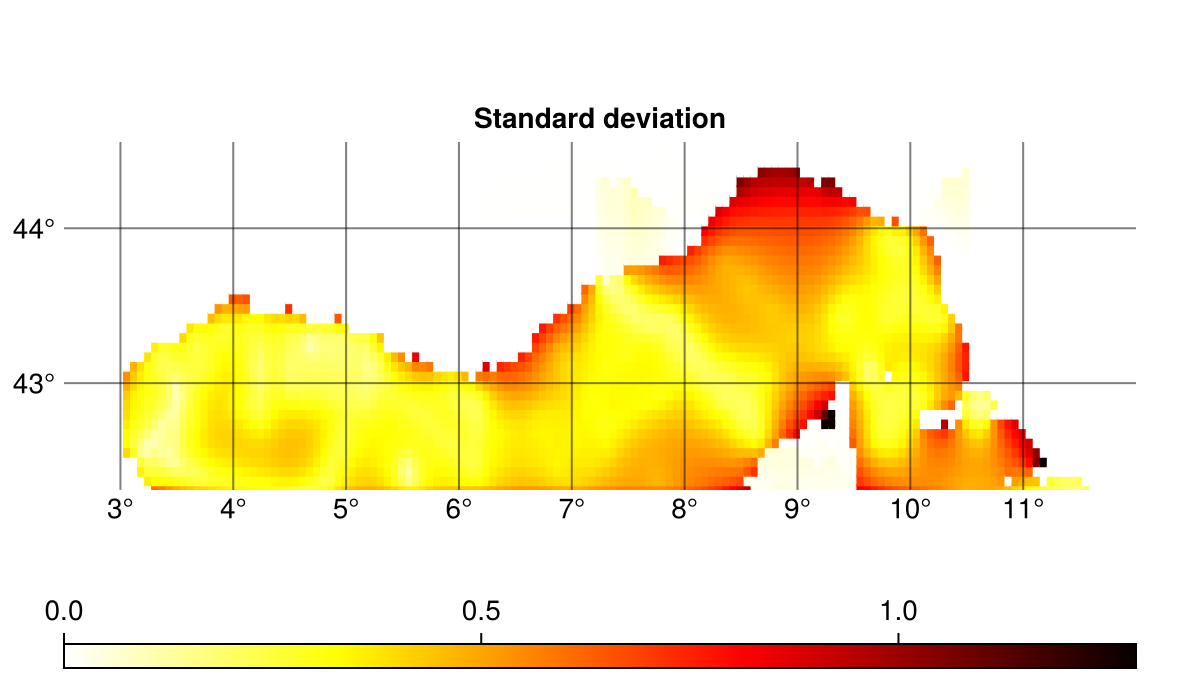

In [19]:
myabserror=sqrt.(sig2.*aerror)
ploterr(myabserror,vmin=0.0,vmax=2*sqrt(sig2), figtitle="Standard deviation")

## How to calculate error on average fields

In [20]:
# if uniform grid is assumed you could use the following two definitions and skip the actual grid surface/volume calculation
gridsurf=ones(Float64,size(s.P)[1],1)
volumes=ones(Float64,size(fi))

# for non-uniform grids, you need to calculate "volumes/surfaces" of each grid box for integration
function volint(mask, pmn)
 NDIM = ndims(mask)
    dim = size(mask)
    # volume based on metrics
    volume = zeros(Float64, dim)
    volume[mask] .= 1.0
    for i = 1:NDIM
        volume .= volume ./ pmn[i]
    end
    return volume
end
# now put volumes from grid into statevector space

volumes=volint(mask,(pm,pn))
gridsurf=statevector_pack(s.sv,(volumes,))
gridsurf=reshape(gridsurf, length(gridsurf), 1)

#Now you have an array of surface in state-space which can be used to integrate

erronmean=diagMtCM(s.P,gridsurf)[1]/((sum(gridsurf))^2)
# That is the error variance of the mean, still scaled by the background error variance (no units)

0.009168814380117605

Now scale by estimate of $\sigma^2$ and take square root:

In [21]:
myabserror=sqrt(sig2*erronmean)

0.06150496897681131

# Mean value of analysed anomalies

In [22]:
mfi=volumes.*fi
meanfi=sum(mfi[.!isnan.(fi)])/sum(volumes[.!isnan.(fi)])

0.15979346644005382

In [23]:
mean(obsval)

37.79835795576099

one sigma range:

In [24]:
[mean(obsval) + meanfi - myabserror, mean(obsval) + meanfi + myabserror]

2-element Vector{Float64}:
 37.896646453224236
 38.01965639117786

# Warning

<div class="alert alert-block alert-warning"> 
⚠️ Always keep in mind that all error estimates are heavily relying on statistical hypothesis and in particular the parameters of the analysis.<br>    
Just try to rerun the notebook by changing the parameters and possibly deactivate the update of epsilon2
</div>

In [25]:
@time fij, sj = DIVAndjog(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2,[4,4],[4,4];alphabc=2.0);

  7.601631 seconds (11.76 M allocations: 670.588 MiB, 2.45% gc time, 99.43% compilation time)


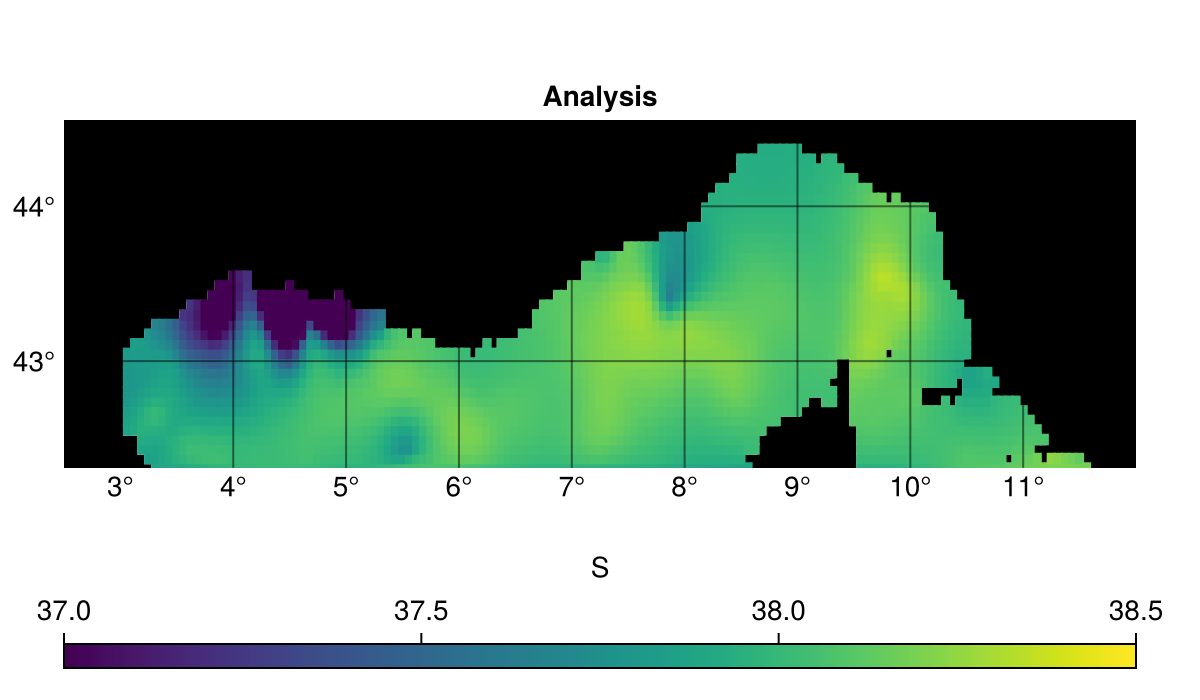

In [26]:
fig = Figure(size = (600, 350))
ga = GeoAxis(fig[1, 1];  dest = "+proj=merc", title = "Analysis", 
xticks=2.:1.:14, yticks=42.:1.:45.)
heatmap!(ga, bx, by, mask, colormap=Reverse(:binary))
hm = heatmap!(ga, lonr, latr, fij .+ mean(obsval), interpolate = false, colorrange=[37., 38.5])
# sc = scatter!(obslon, obslat, color=obsval, markersize=7, colorrange=[37., 38.5])
xlims!(ga, (bx[1], bx[end]))
ylims!(ga, (by[1], by[end]))
Colorbar(fig[2, 1], hm, vertical = false, label = "S")
fig